<a href="https://colab.research.google.com/github/onionminion/Cardiac-Arrhythmia-Detection-from-ECG-Data/blob/main/Arrhythmia%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import torch.optim as optim

Matplotlib Settings

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

Methods Definitions

In [ ]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec

Variables Definitions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

##Prepare Input Files

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

In [ ]:
# segregating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

##Data Extraction and Preprocessing

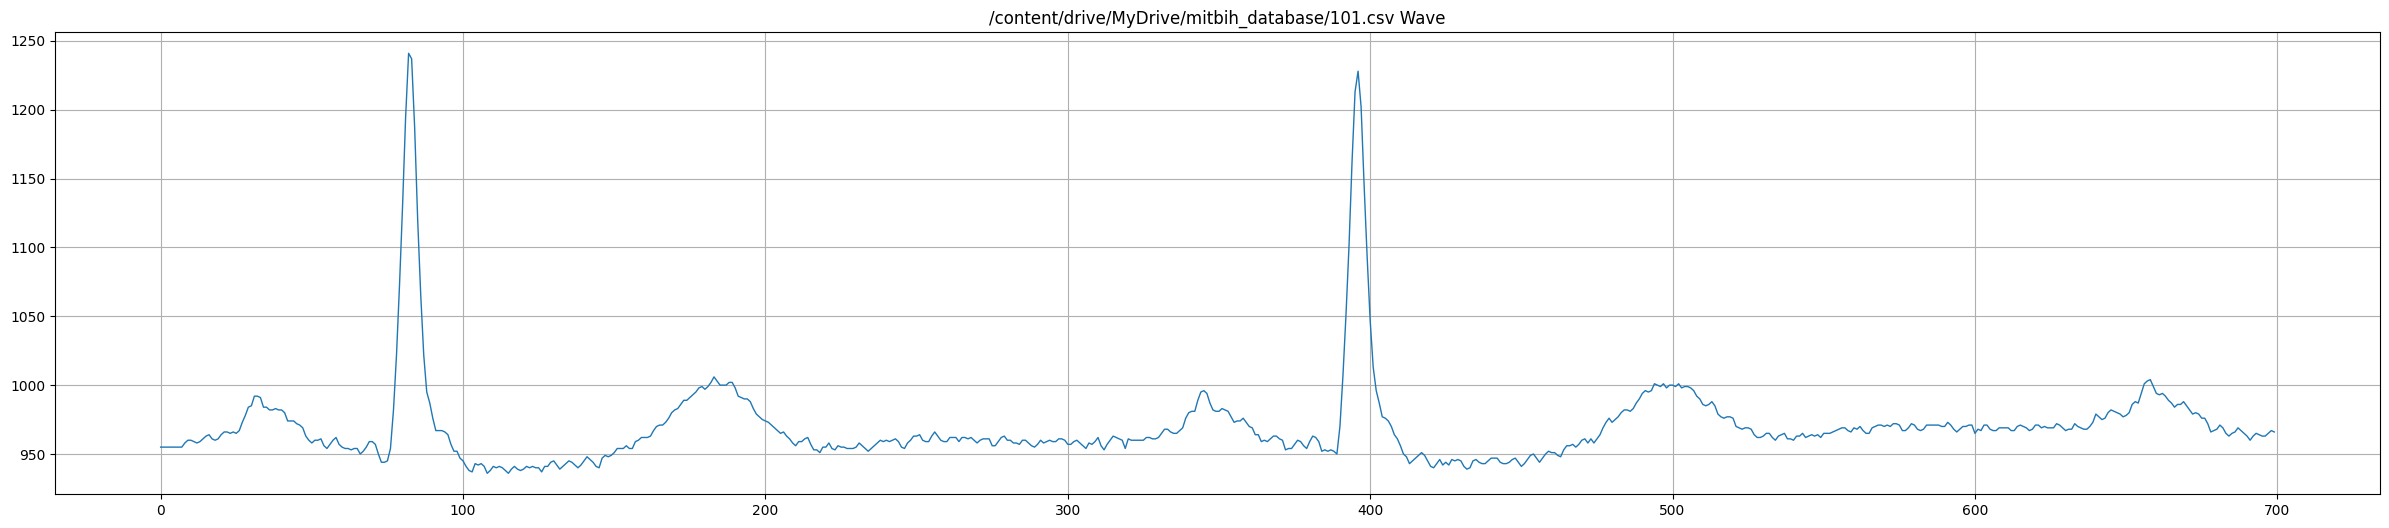

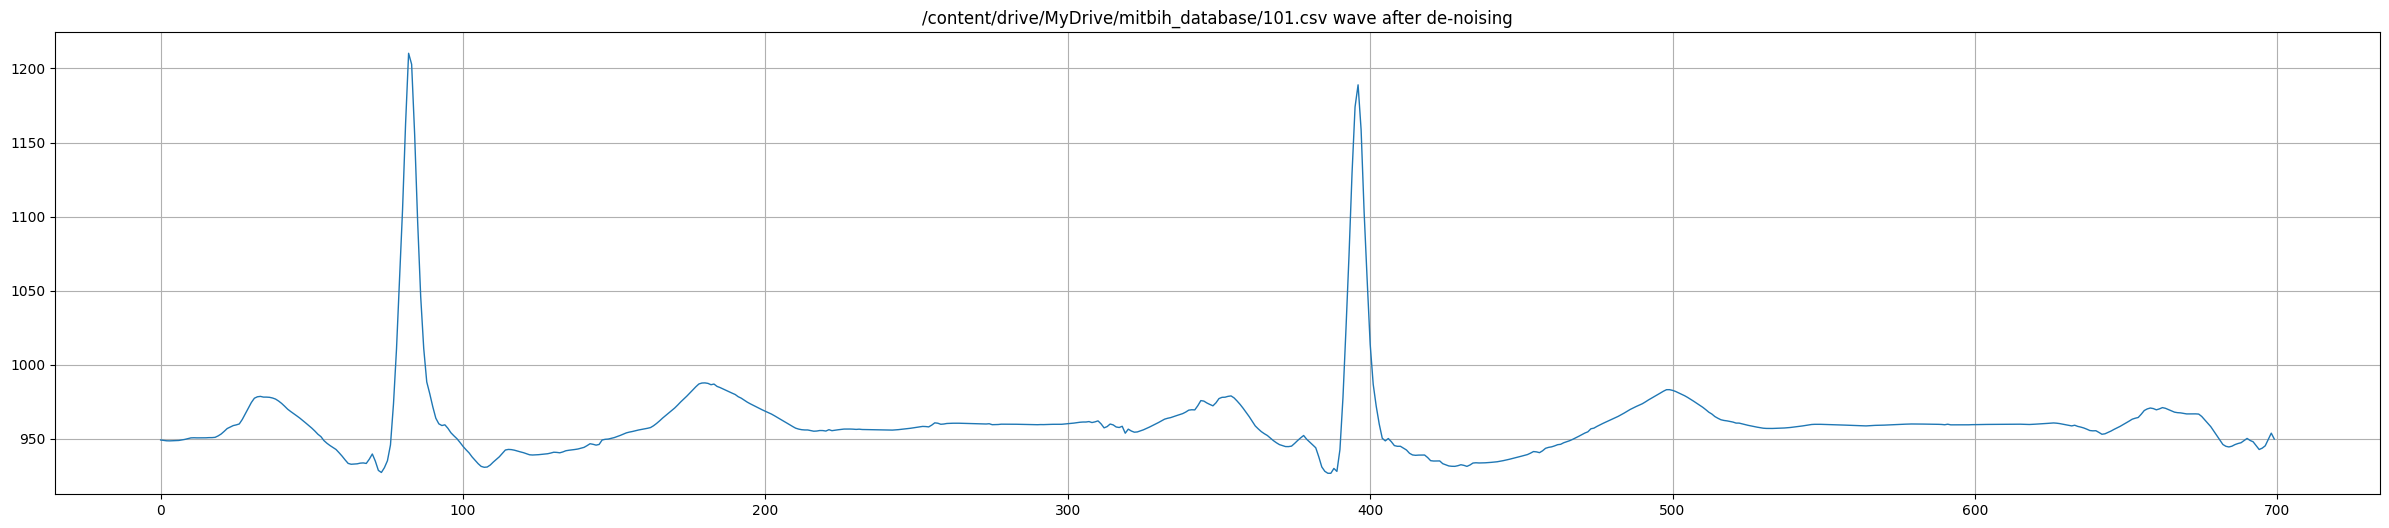

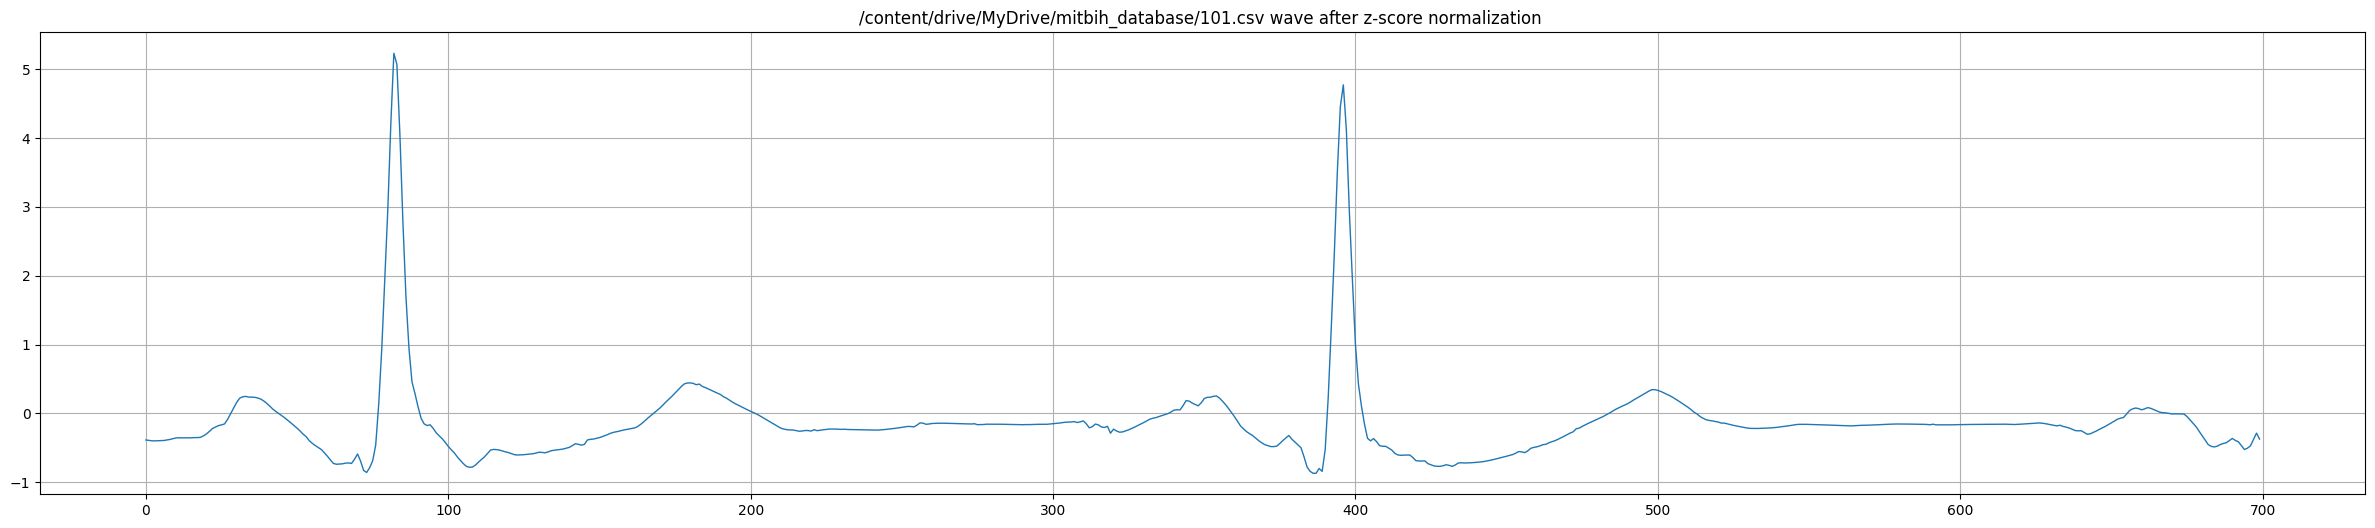

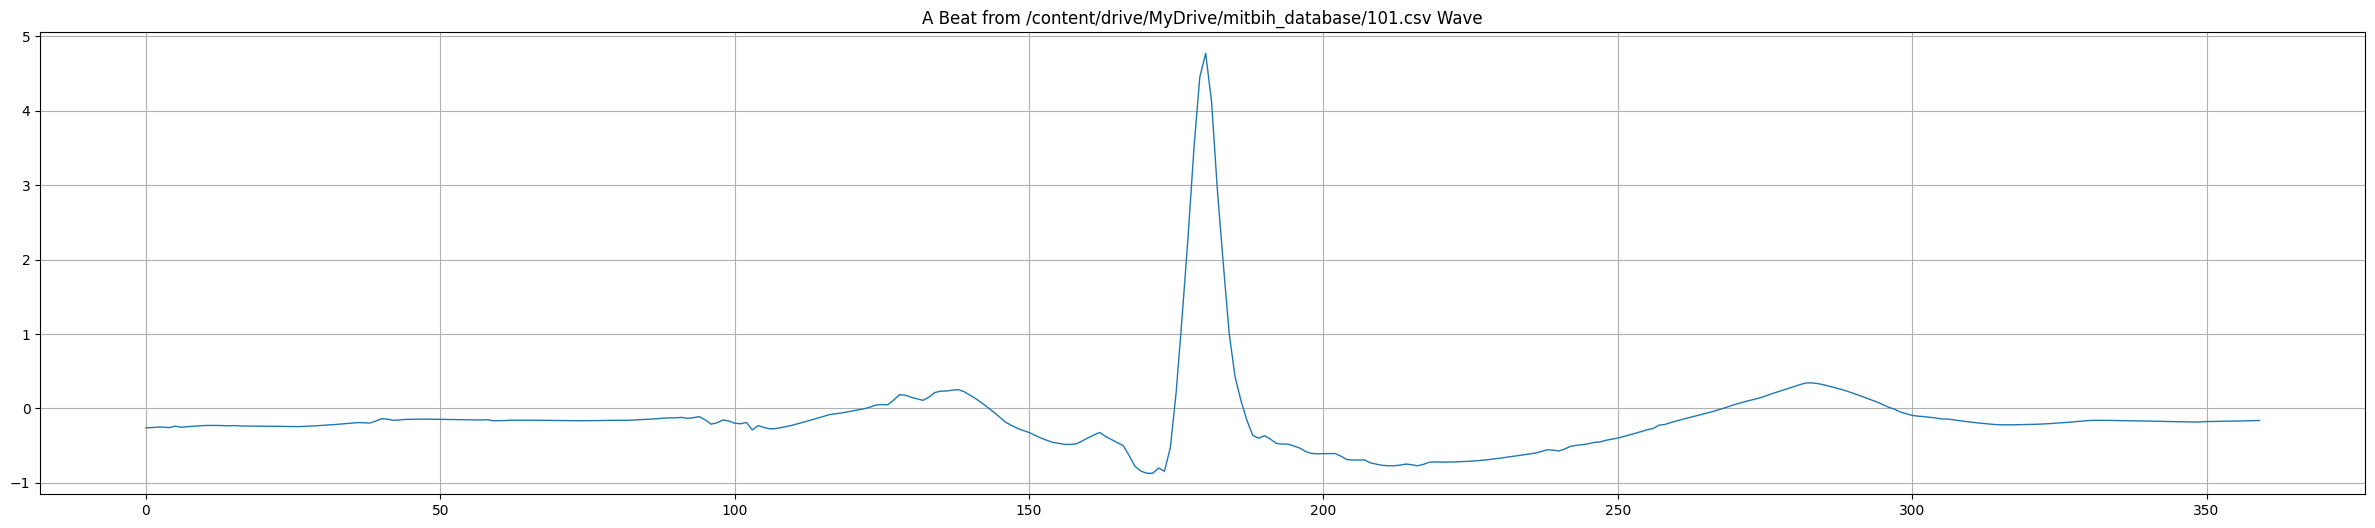

(100012, 360) (100012,)


In [ ]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after de-noising")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)

                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]
                    # Plot an example to a beat
                    if r == 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [ ]:
X_df=pd.DataFrame(X)
y_df=pd.DataFrame(y)
X_df[360]=y_df

In [ ]:
per_class = X_df[X_df.shape[1]-1].value_counts()

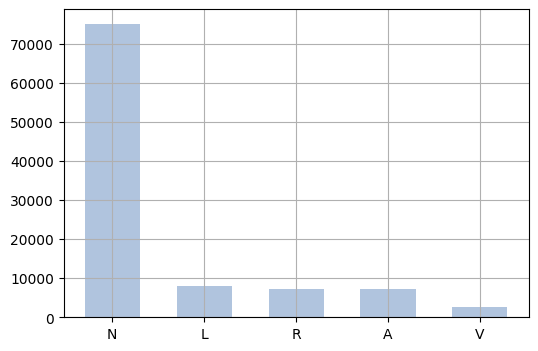

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(['N', 'L', 'R', 'A', 'V'], per_class, color ='lightsteelblue',
        width = 0.6)
plt.show()

In [ ]:
df_1=X_df[X_df[X_df.shape[1]-1]==1]
df_2=X_df[X_df[X_df.shape[1]-1]==2]
df_3=X_df[X_df[X_df.shape[1]-1]==3]
df_4=X_df[X_df[X_df.shape[1]-1]==4]
df_0=(X_df[X_df[X_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
X_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
77042,-1.680959,-1.659245,-1.633256,-1.602367,-1.570746,-1.537908,-1.501199,-1.463844,-1.432589,-1.403449,...,-0.991127,-0.991216,-0.988218,-0.984140,-0.978679,-0.972664,-0.966162,-0.958416,-0.950360,0
51230,-0.292774,-0.268355,-0.242973,-0.218719,-0.194505,-0.166678,-0.138870,-0.111956,-0.086613,-0.070647,...,-0.260494,-0.253279,-0.245243,-0.236866,-0.229991,-0.224125,-0.214610,-0.202842,-0.204465,0
46415,-0.245069,-0.247447,-0.241855,-0.221402,-0.199468,-0.201038,-0.193836,-0.250902,-0.225642,-0.176911,...,-0.148711,-0.126511,-0.142611,-0.161731,-0.153191,-0.192621,-0.153642,-0.106343,-0.131720,0
25690,-0.649717,-0.642706,-0.637089,-0.632181,-0.625337,-0.618411,-0.611368,-0.604798,-0.602013,-0.600907,...,-1.387854,-1.377446,-1.367678,-1.358452,-1.349109,-1.336963,-1.322018,-1.310993,-1.309391,0
32029,-0.174938,-0.170075,-0.183134,-0.166396,-0.176061,-0.163881,-0.164358,-0.154193,-0.155828,-0.144012,...,-0.126126,-0.129452,-0.130908,-0.136692,-0.135770,-0.126619,-0.155829,-0.140649,-0.127331,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62574,-0.295443,-0.282020,-0.314785,-0.304712,-0.316547,-0.325500,-0.333263,-0.342388,-0.337477,-0.352993,...,-0.152430,-0.154993,-0.159247,-0.165455,-0.172687,-0.178794,-0.186440,-0.190297,-0.186199,4
43810,2.149784,1.750365,1.307845,0.681316,0.053408,-0.382085,-0.586079,-0.637357,-0.604070,-0.514104,...,0.183678,0.183915,0.180782,0.193172,0.184771,0.186667,0.186038,0.192884,0.187890,4
55926,-0.352329,-0.370749,-0.383749,-0.390506,-0.389582,-0.375241,-0.349470,-0.318251,-0.277177,-0.215388,...,-0.352375,-0.352186,-0.352419,-0.352507,-0.352714,-0.352508,-0.350232,-0.346941,-0.343195,4
79930,4.631876,5.216779,5.563217,5.468084,4.828041,3.808149,2.605932,1.371079,0.249672,-0.487296,...,0.215189,0.213954,0.218124,0.233903,0.189475,0.205103,0.225428,0.257264,0.241486,4


0    5000
1    5000
2    5000
3    5000
4    5000
Name: 360, dtype: int64


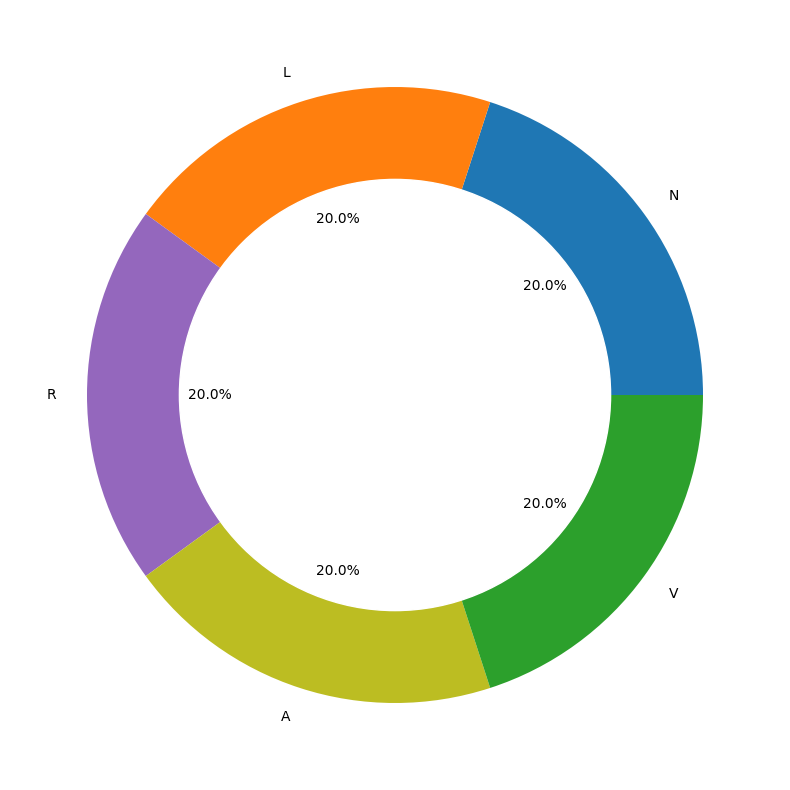

In [ ]:
per_class = X_df[X_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Train test split

In [ ]:
y_df2=X_df[360]
X_df2=X_df.drop(columns=[360])

In [ ]:
y_df2=y_df2.to_numpy()
X_df2=X_df2.to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df2, y_df2, test_size=0.2, random_state=42,stratify=y_df2)

In [ ]:
# Reshape the input data for PyTorch (add channel dimension)
X_train = X_train.reshape((-1, 1, 360))
X_test = X_test.reshape((-1, 1, 360))

In [ ]:
np.shape(X_train)

(20000, 1, 360)

##Prepare dataset & dataloader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# Convert numpy arrays to PyTorch tensors and move to the GPU
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

In [ ]:
# Create dataloaders for batching the data
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


#1. Method: CNN

####a. CNN


1.   Convolutional layer
2.   2 Fully connected layer
3.   RelU activation function
4.   Pooling layers using MaxPool
5.   Batch normalization



In [ ]:
# Define the CNN model
class ECGClassifier(nn.Module):
    def __init__(self):
        super(ECGClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=13, padding=6, stride=1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=15, padding=7, stride=1)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=17, padding=8, stride=1)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=19, padding=9, stride=1)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(2816, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 5)  # 5 output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        return x

###b. CNN without batch normalization


1.   Convolutional layer
2.   2 Fully connected layer
3.   RelU activation function
4.   Pooling layers using AvgPool
5.   Dropout layer


In [ ]:
class ECGClassifier2(nn.Module):
    def __init__(self):
        super(ECGClassifier2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=13, padding=6)
        self.relu1 = nn.ReLU()
        self.avgpool1 = nn.AvgPool1d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=15, padding=7)
        self.relu2 = nn.ReLU()
        self.avgpool2 = nn.AvgPool1d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=17, padding=8)
        self.relu3 = nn.ReLU()
        self.avgpool3 = nn.AvgPool1d(kernel_size=3, stride=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=19, padding=9)
        self.relu4 = nn.ReLU()
        self.avgpool4 = nn.AvgPool1d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(2688, 35)
        self.dense2 = nn.Linear(35, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avgpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.avgpool4(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

####c. CNN with LSTM attention


CNN from Model 1 is used as a feature extractor to process the input data and the output is used for LSTM.

In [ ]:
class ECGClassifier3(nn.Module):
    def __init__(self):
        super(ECGClassifier3, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=13, padding=6, stride=1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=15, padding=7, stride=1)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=17, padding=8, stride=1)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=19, padding=9, stride=1)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(64 * 2, 1)

        self.fc1 = nn.Linear(64 * 2, 128)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # LSTM layer
        x, _ = self.lstm(x.transpose(1, 2))

        # Attention mechanism
        attention_weights = F.softmax(self.attention(x), dim=1)
        x = torch.sum(x * attention_weights, dim=1)

        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        return x

#2. Method: ResNet


ResNet-34 architecture with FFT-based transformation  
1. Convolutional layers
2. Batch normalization
3. RelU actviation
4. MaxPool
5. Fully connected layers

In [ ]:
import torch
import torch.nn as nn


class ECGClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super(ECGClassifierResNet, self).__init__()
        self.num_classes = num_classes

        # ResNet architecture
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=(2, 2))
        self.layer3 = self._make_layer(128, 256, 6, stride=(2, 2))
        self.layer4 = self._make_layer(256, 512, 3, stride=(2, 2))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=(1, 1)):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.fft.fft(x)
        x = x.abs()
        x = x.view(x.size(0), 1, x.size(1), -1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=(1, 1)):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != (1, 1) or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=stride, bias=False),
                                          nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

Resnet - 101
The code works but it's taking super long to run the code. Hence, we tried it with Resnet-34 instead


In [ ]:
class ECGClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super(ECGClassifierResNet, self).__init__()
        self.num_classes = num_classes

        # FFT-based input processing
        self.fft_layer = nn.Linear(360, 360)

        # ResNet architecture
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.layer1 = self._make_layer(64, 3)  # 64 * 4 = 256
        self.layer2 = self._make_layer(256, 4, stride=2)  # 256 * 4 = 1024
        self.layer3 = self._make_layer(1024, 23, stride=2)  # 1024 * 4 = 4096
        self.layer4 = self._make_layer(4096, 3, stride=2)  # 4096 * 4 = 16384
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16384, num_classes)

    def _make_layer(self, in_channels, num_blocks, stride=1):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BottleneckBlock(in_channels, in_channels * BottleneckBlock.expansion, stride))
            in_channels *= BottleneckBlock.expansion
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.fft_layer(x)
        x = x.view(x.size(0), 1, 360, 1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=(1, 1)):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels//self.expansion, kernel_size=(1, 1), stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels//self.expansion)
        self.conv2 = nn.Conv2d(out_channels//self.expansion, out_channels//self.expansion, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels//self.expansion)
        self.conv3 = nn.Conv2d(out_channels//self.expansion, out_channels, kernel_size=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != (1, 1) or in_channels != out_channels:
            self.shortcut = nn.Sequential( nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=stride, bias=False),nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.shortcut(identity)

        out += identity
        out = self.relu(out)

        return out

#3. Method: AlexNet

In [ ]:
import torch
import torch.nn as nn
import torch.fft

class FFTLayer(nn.Module):
    def __init__(self):
        super(FFTLayer, self).__init__()

    def forward(self, x):
        x = torch.fft.fft(x)
        return x

class ECGClassifierAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(ECGClassifierAlexNet, self).__init__()
        self.fft_layer = FFTLayer()
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(11,1), stride=(4,1), padding=(2,0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,1), stride=(2,1)),
            nn.Conv2d(64, 192, kernel_size=(5,1), padding=(2,0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,1), stride=(2,1)),
            nn.Conv2d(192, 384, kernel_size=(3,1), padding=(1,0)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3,1), padding=(1,0)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3,1), padding=(1,0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,1), stride=(2,1)),)

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),)

    def forward(self, x):
        x = self.fft_layer(x)
        x = torch.abs(x)
        x = x.view(x.size(0), 1, 180, 2)

        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x


# 4. Method: CapsNet

In [ ]:
import torch
import torch.nn as nn
import torch.fft

import torch
import torch.nn as nn

class ECGClassifierCapsNet(nn.Module):
    def __init__(self, num_classes):
        super(ECGClassifierCapsNet, self).__init__()
        self.num_classes = num_classes

        # FFT-based input processing
        self.fft_layer = nn.Linear(360, 360)

        # CapsNet architecture
        self.conv1 = nn.Conv1d(1, 64, kernel_size=9, stride=1, padding=4, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.fft_layer(x)
        x = x.unsqueeze(1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

class CapsuleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)

        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.shortcut is not None:
            identity = self.shortcut(identity)

        x += identity
        x = self.relu(x)

        return x

#Print training model result

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import time

def precision_recall_fscore(gt, pred):
    prec, rec, f, _ = precision_recall_fscore_support(gt, pred)
    return prec, rec, f

def result(model, optimizer, criterion):
    # Training loop
    num_epochs = 50
    train_losses = []
    test_losses = []
    test_accuracies = []
    precisions = np.zeros((num_epochs, 5))
    recalls = np.zeros((num_epochs, 5))
    fscores = np.zeros((num_epochs, 5))

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_inputs, batch_labels in train_dataloader:
            optimizer.zero_grad()
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            batch_outputs = model(batch_inputs)
            loss = criterion(batch_outputs, batch_labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_inputs.size(0)
        train_loss /= len(train_dataloader.dataset)

        # Evaluation loop
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            test_loss = 0.0
            pred = []
            gt = []
            for batch_inputs, batch_labels in test_dataloader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device)
                batch_outputs = model(batch_inputs)

                # Calculate loss and accuracy
                loss = criterion(batch_outputs, batch_labels)
                test_loss += loss.item() * batch_inputs.size(0)

                _, predicted = torch.max(batch_outputs, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
                pred += predicted.cpu()
                gt += batch_labels.cpu()

            test_loss /= len(test_dataloader.dataset)
            test_accuracy = correct / total
            precision, recall, fscore = precision_recall_fscore(gt, pred)

        # Store values for plotting
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        precisions[epoch] = precision
        recalls[epoch] = recall
        fscores[epoch] = fscore

        # Print epoch results
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.2%}")
        print(f"Test Precision: {precision:.2%}")
        print(f"Test Recall: {recall:.2%}")
        print(f"Test F-score: {fscore:.2%}")
    time_elapsed = time.time() - start_time
    print(f"Total time elapsed: {time_elapsed:.2f} seconds")

    # Plot the loss and accuracy graphs
    plt.figure(figsize=(12, 10))
    plt.subplot(3, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(3, 2, 3)
    for i in range(5):
        plt.plot(range(1, num_epochs + 1), precisions[:, i], label=i)
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(3, 2, 4)
    for i in range(5):
        plt.plot(range(1, num_epochs + 1), recalls[:, i], label=i)
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()

    plt.subplot(3, 2, 5)
    for i in range(5):
        plt.plot(range(1, num_epochs + 1), fscores[:, i], label=i)
    plt.xlabel("Epoch")
    plt.ylabel("F-score")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


def result(model, optimizer, criterion):
  start_time = time.time()
  # Training loop
  num_epochs = 50
  train_losses = []
  test_losses = []
  test_accuracies = []
  precisions = []
  recalls = []
  fscores = []

  for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0
      for batch_inputs, batch_labels in train_dataloader:
          optimizer.zero_grad()
          batch_inputs = batch_inputs.to(device)
          batch_labels = batch_labels.to(device)
          batch_outputs = model(batch_inputs)
          loss = criterion(batch_outputs, batch_labels)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          train_loss += loss.item() * batch_inputs.size(0)
      train_loss /= len(train_dataloader.dataset)

      # Evaluation loop
      model.eval()
      with torch.no_grad():
          correct = 0
          total = 0
          test_loss = 0.0
          pred = []
          gt = []
          for batch_inputs, batch_labels in test_dataloader:
              batch_inputs = batch_inputs.to(device)
              batch_labels = batch_labels.to(device)
              batch_outputs = model(batch_inputs)

              # Calculate loss and accuracy
              loss = criterion(batch_outputs, batch_labels)
              test_loss += loss.item() * batch_inputs.size(0)

              _, predicted = torch.max(batch_outputs, 1)
              total += batch_labels.size(0)
              correct += (predicted == batch_labels).sum().item()
              pred += predicted.cpu()
              gt += batch_labels.cpu()

          test_loss /= len(test_dataloader.dataset)
          test_accuracy = correct / total
          precision, recall, fscore = precision_recall_fscore(gt, pred)

      # Store values for plotting
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)
      precisions.append(precision)
      recalls.append(recall)
      fscores.append(fscore)

      # Print epoch results
      print(f"Epoch {epoch + 1}/{num_epochs}:")
      print(f"Train Loss: {train_loss:.4f}")
      print(f"Test Loss: {test_loss:.4f}")
      print(f"Test Accuracy: {test_accuracy:.2%}")
      print(f"Test Precision: {precision:.2%}")
      print(f"Test Recall: {recall:.2%}")
      print(f"Test F-score: {fscore:.2%}")

  # Plot the loss and accuracy graphs
  plt.figure(figsize=(12, 10))
  plt.subplot(3, 1, 1)
  plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
  plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(3, 1, 2)
  plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.subplot(3, 2, 3)
  plt.plot(range(1, num_epochs + 1), precisions, label="Test Precision")
  plt.plot(range(1, num_epochs + 1), precisions, label=classes)
  plt.xlabel("Epoch")
  plt.ylabel("Precision")
  plt.legend()

  plt.subplot(3, 2, 4)
  plt.plot(range(1, num_epochs + 1), recalls, label="Test Recall")
  plt.plot(range(1, num_epochs + 1), precisions, label=classes)
  plt.xlabel("Epoch")
  plt.ylabel("Recall")
  plt.legend()

  plt.subplot(3, 1, 3)
  plt.plot(range(1, num_epochs + 1), fscores, label="Test F-score")
  plt.plot(range(1, num_epochs + 1), fscores, label=classes)
  plt.xlabel("Epoch")
  plt.ylabel("F-score")
  plt.legend()

  plt.tight_layout()
  plt.show()

  end_time = time.time()
  print("running time:",  end_time - start_time)

  print(test_accuracies)
  print(fscores)
  print("\n\n\n")
  print("Final test accuracy:",test_accuracies[-1])
  print("Final fscore:",fscores[-1])


#Train model result

1. Model 1: CNN with batch normalization with Max pooling


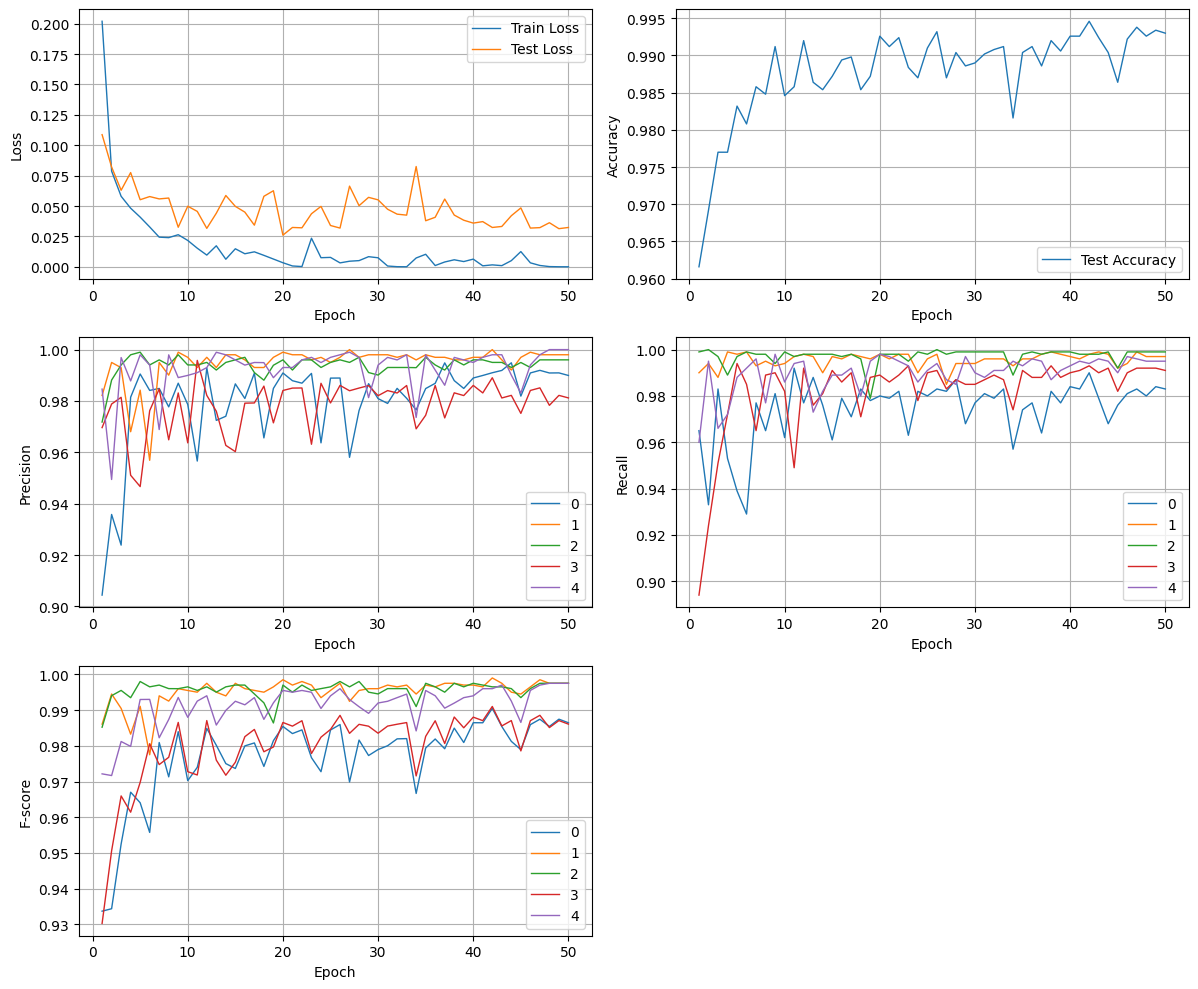

In [ ]:
model = ECGClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
result(model, optimizer, criterion)

2. Model 2: CNN with drop layer

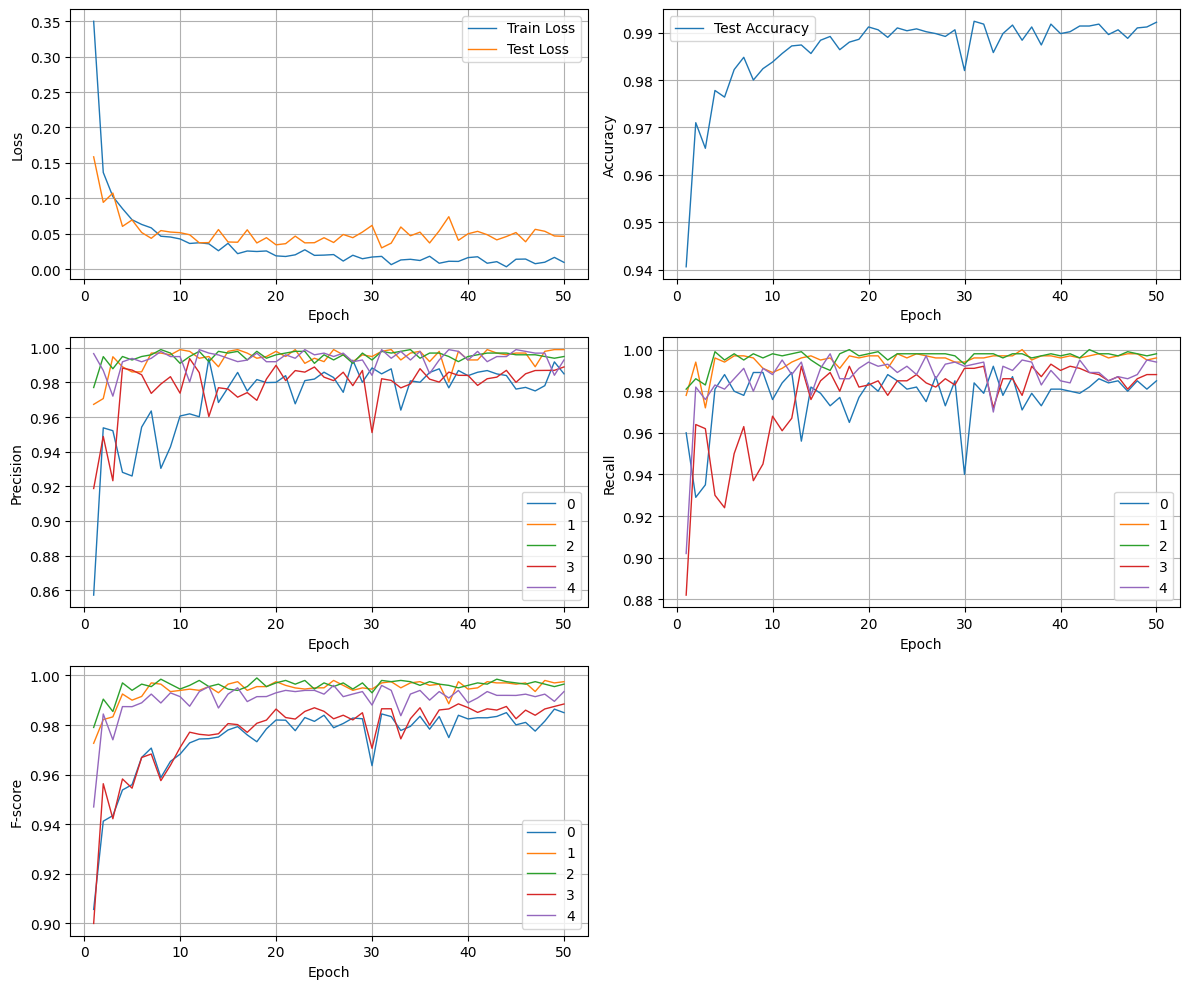

In [ ]:
model = ECGClassifier2().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
result(model, optimizer, criterion)

3. Model 3: CNN with model 1 and LSTM attention

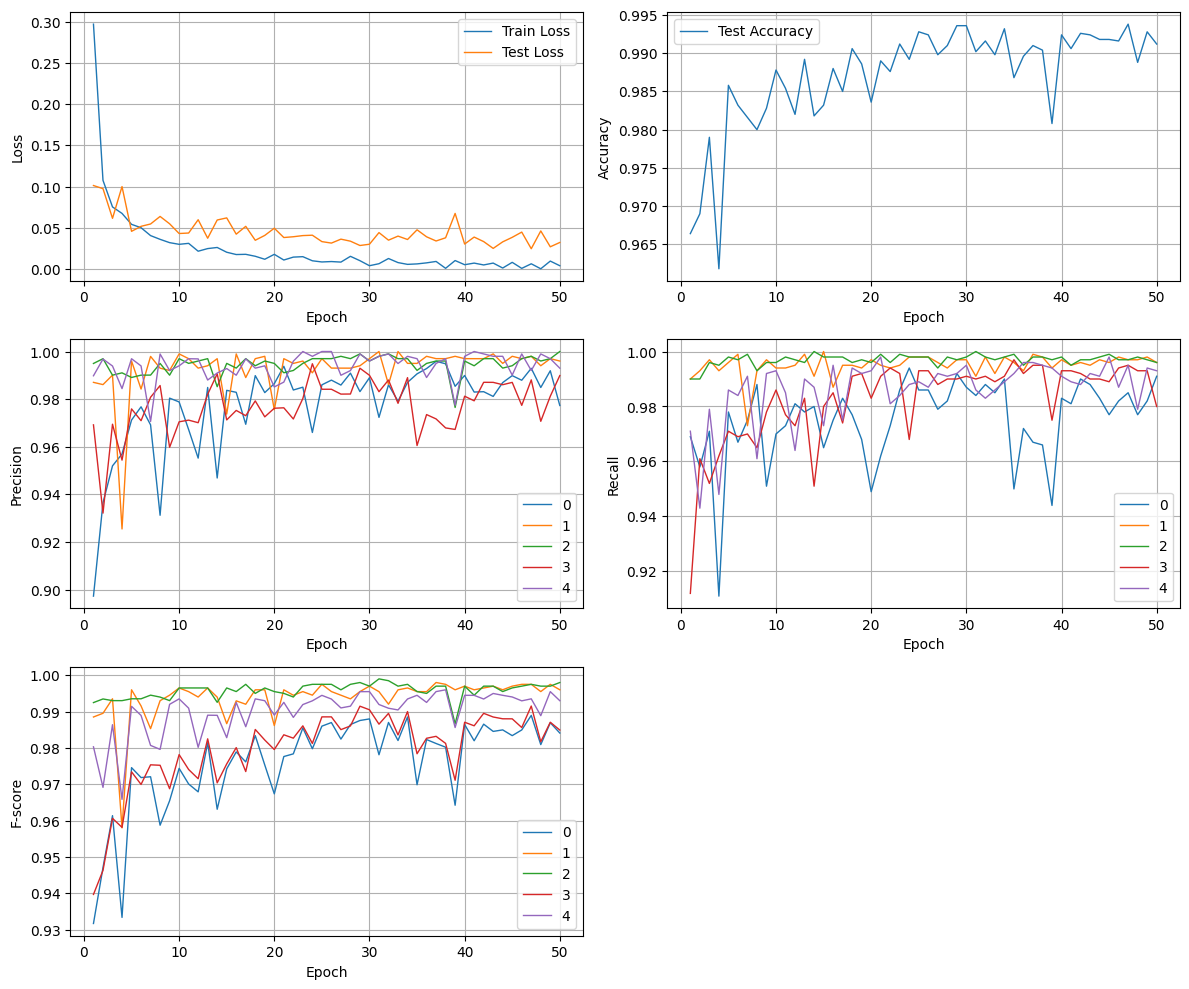

In [ ]:
model = ECGClassifier3().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
result(model, optimizer, criterion)

4. Model 4: ResNet-101 with FFT

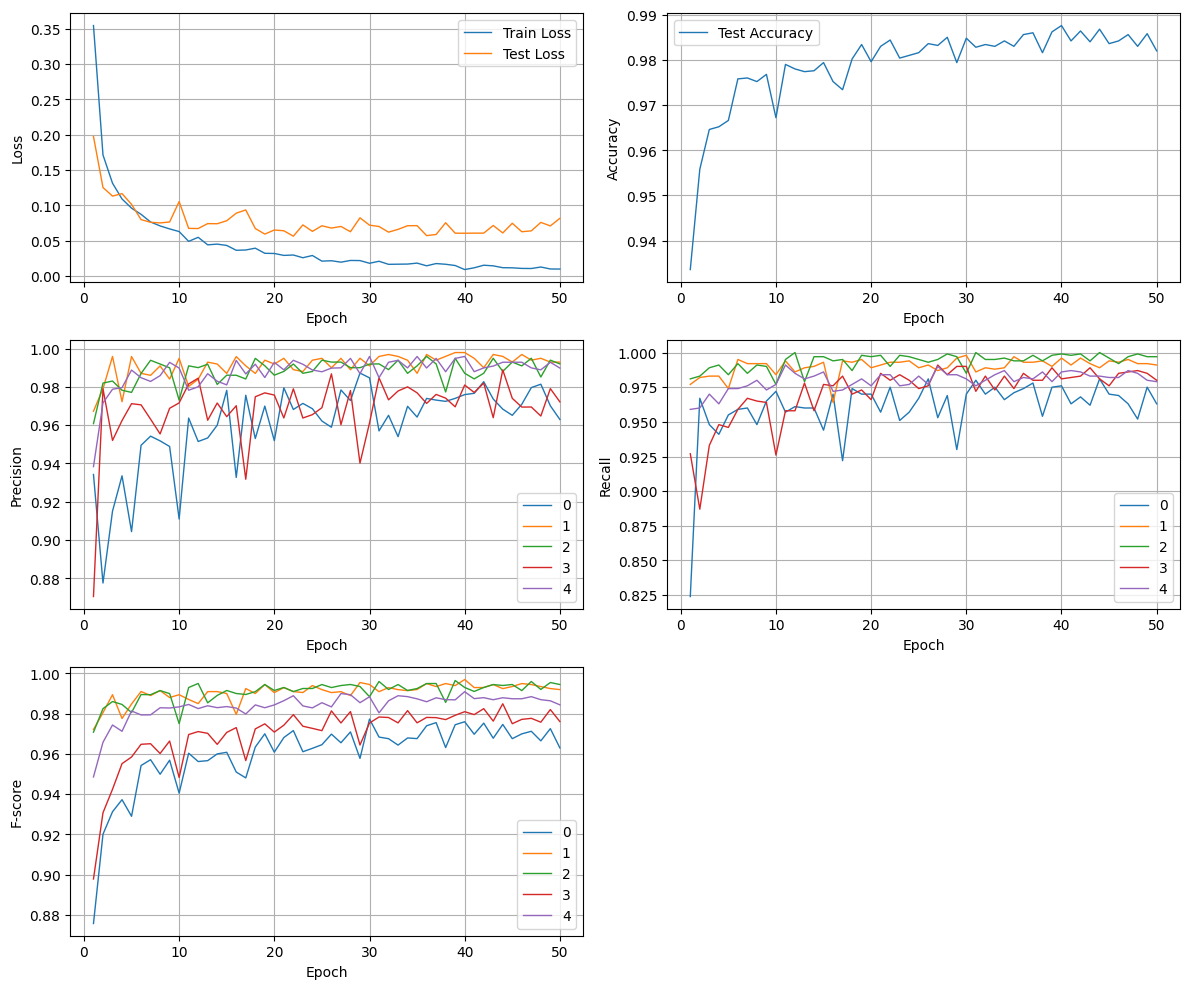

In [ ]:
model = ECGClassifierResNet(num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
result(model, optimizer, criterion)

5. Model 5: AlexNet with FFT

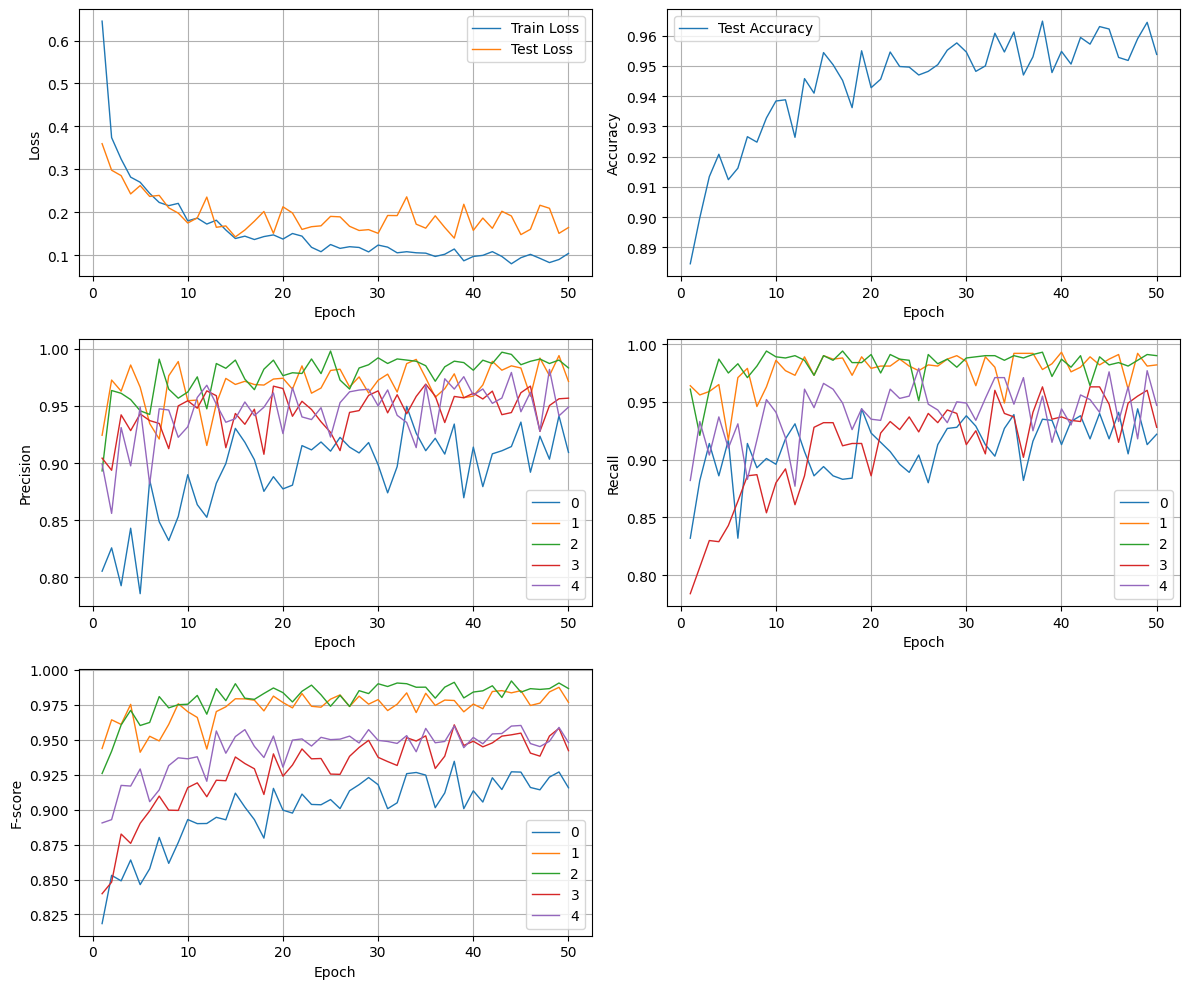

In [ ]:
model = ECGClassifierAlexNet(num_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
result(model, optimizer, criterion)

#Experiments

In [ ]:
def compare_result(model1, model2, optimizer1, optimizer2, criterion):
    # Training loop
    num_epochs = 15
    test_losses = []
    test_accuracies1 = []
    test_accuracies2 = []

    for epoch in range(num_epochs):
        model1.train()
        model2.train()

        print(f"Epoch {epoch + 1}/{num_epochs}:")

        for batch_inputs, batch_labels in train_dataloader:
            # optimizer.zero_grad()
            # optimizer.zero_grad()
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            batch_outputs1 = model1(batch_inputs)
            batch_outputs2 = model2(batch_inputs)
            loss1 = criterion(batch_outputs1, batch_labels)
            loss2 = criterion(batch_outputs2, batch_labels)

            # Backward pass and optimization
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()

        # Evaluation loop
        model1.eval()
        model2.eval()
        with torch.no_grad():
            correct1 = 0
            correct2 = 0
            total = 0
            test_loss1 = 0.0
            test_loss2 = 0.0
            pred1 = []
            pred2 = []
            gt = []
            for batch_inputs, batch_labels in test_dataloader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device)
                batch_outputs1 = model1(batch_inputs)
                batch_outputs2 = model2(batch_inputs)

                # Calculate loss and accuracy for model1
                loss1 = criterion(batch_outputs1, batch_labels)
                test_loss1 += loss1.item() * batch_inputs.size(0)
                _, predicted1 = torch.max(batch_outputs1, 1)
                correct1 += (predicted1 == batch_labels).sum().item()

                # Calculate loss and accuracy for model2
                loss2 = criterion(batch_outputs2, batch_labels)
                test_loss2 += loss2.item() * batch_inputs.size(0)
                _, predicted2 = torch.max(batch_outputs2, 1)
                correct2 += (predicted2 == batch_labels).sum().item()

                total += batch_labels.size(0)
                pred1 += predicted1.cpu()
                pred2 += predicted2.cpu()
                gt += batch_labels.cpu()

            test_accuracy1 = correct1 / total
            test_accuracy2 = correct2 / total

        # Store values for plotting
        test_accuracies1.append(test_accuracy1)
        test_accuracies2.append(test_accuracy2)

    return test_accuracies1, test_accuracies2


###1. CNN with single-directional LSTM Attention

In [ ]:
class ECGClassifierCNNSSingle(nn.Module):
    def __init__(self):
        super(ECGClassifierCNNSSingle, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=13, padding=6, stride=1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=15, padding=7, stride=1)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=17, padding=8, stride=1)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=19, padding=9, stride=1)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(128, 64, batch_first=True)
        self.attention = nn.Linear(64, 1)

        self.fc1 = nn.Linear(64, 128)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # LSTM layer
        x, _ = self.lstm(x.transpose(1, 2))

        # Attention mechanism
        attention_weights = F.softmax(self.attention(x), dim=1)
        x = torch.sum(x * attention_weights, dim=1)

        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        return x

In [ ]:
model1 = ECGClassifier3().to(device)
model2 = ECGClassifierCNNSSingle().to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

test_accuracies1, test_accuracies2 = compare_result(model1, model2, optimizer1, optimizer2, criterion)

Epoch 1/50:
Epoch 2/50:
Epoch 3/50:
Epoch 4/50:
Epoch 5/50:
Epoch 6/50:
Epoch 7/50:
Epoch 8/50:
Epoch 9/50:
Epoch 11/50:
Epoch 12/50:
Epoch 13/50:
Epoch 14/50:
Epoch 15/50:
Epoch 16/50:
Epoch 17/50:
Epoch 18/50:
Epoch 19/50:
Epoch 20/50:
Epoch 21/50:
Epoch 22/50:
Epoch 23/50:
Epoch 24/50:
Epoch 25/50:
Epoch 26/50:
Epoch 27/50:
Epoch 28/50:
Epoch 29/50:
Epoch 30/50:
Epoch 31/50:
Epoch 32/50:
Epoch 33/50:
Epoch 34/50:
Epoch 35/50:
Epoch 36/50:
Epoch 37/50:
Epoch 38/50:
Epoch 39/50:
Epoch 40/50:
Epoch 41/50:
Epoch 42/50:
Epoch 43/50:
Epoch 44/50:
Epoch 45/50:
Epoch 46/50:
Epoch 47/50:
Epoch 48/50:
Epoch 49/50:
Epoch 50/50:


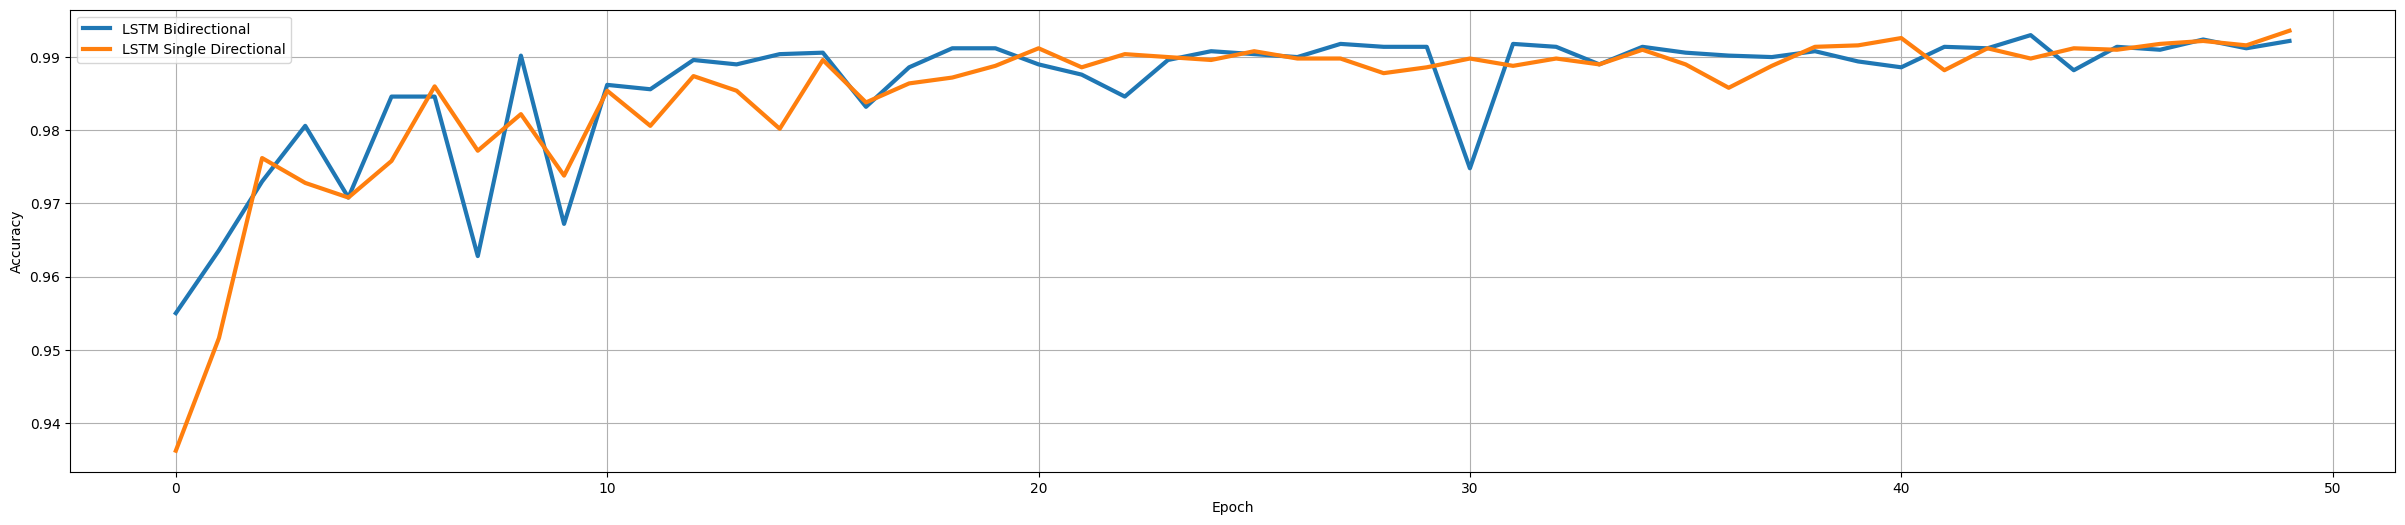

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_accuracies1, label='LSTM Bidirectional', linewidth=3)
plt.plot(test_accuracies2, label='LSTM Single Directional', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_accuracies1[-1]

0.9922

In [ ]:
test_accuracies2[-1]

0.9936

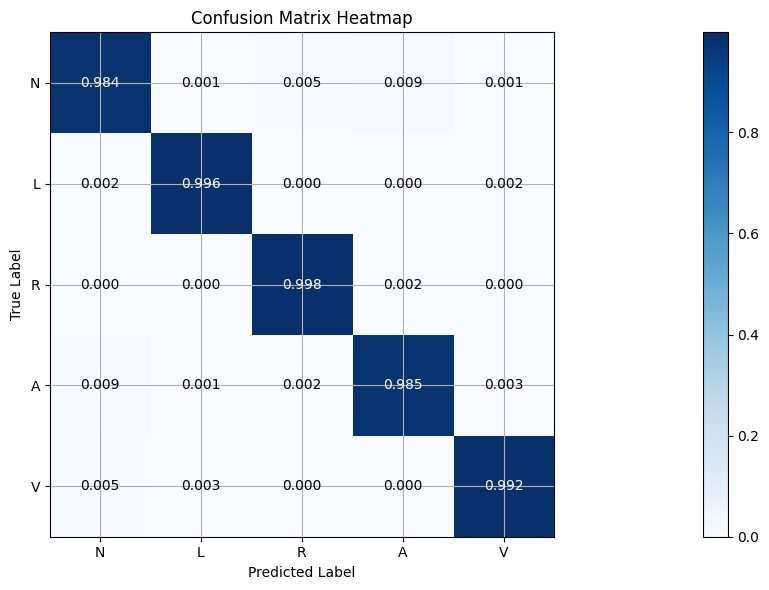

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

confusion_matrix = np.array([[984, 1, 5, 9, 1],
                             [2, 996, 0, 0, 2],
                             [0, 0, 998, 2, 0],
                             [9, 1, 2, 985, 3],
                             [5, 3, 0, 0, 992]])

# Calculate proportions
row_sums = confusion_matrix.sum(axis=1)
proportions = confusion_matrix / row_sums[:, np.newaxis]

# Create a figure and axes
fig, ax = plt.subplots()

# Create the heatmap
heatmap = ax.imshow(proportions, cmap='Blues')

# Set the title and axis labels
ax.set_title('Confusion Matrix Heatmap')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Create colorbar
cbar = plt.colorbar(heatmap)

# Set the tick labels
classes = ['N', 'L', 'R', 'A', 'V']
tick_labels = classes
ax.set_xticks(np.arange(len(tick_labels)))
ax.set_yticks(np.arange(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Loop over data dimensions and create text annotations
for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        color = 'white' if proportions[i, j] > 0.5 else 'black'  # Set font color to white for darker cells
        text = ax.text(j, i, f'{proportions[i, j]:.3f}',
                       ha='center', va='center', color=color)

plt.tight_layout()
plt.show()
